# movesense measurements
convert the movesense measurements into a form comparable to the equivital recordings for analysis

In [113]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d
import heartpy as hp

In [149]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport mvss
%aimport qex
%aimport al

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
%reload_ext autoreload

## initial data conversion from json to csv

In [115]:
Part_Dets = pd.read_csv('../Data/Participant_Metadata.csv', index_col = 0)
Part_Dets.columns
Part_Dets

MS_users = Part_Dets.loc[Part_Dets.loc[:,['P_RG','P_RE', 'P_RD', 'P_C1', 'P_C2', 'P_C3', 'P_C4', 'P_C5']].sum(axis=1)<10000,
                         ['P_RG','P_RE', 'P_RD', 'P_C1', 'P_C2', 'P_C3', 'P_C4', 'P_C5']]
for c in ['P_RG','P_RE', 'P_RD', 'P_C1', 'P_C2', 'P_C3', 'P_C4', 'P_C5']:
    MS_users.loc[MS_users.loc[:,c].isna(),c] = 0.0
    MS_users.loc[:,c] = MS_users.loc[:,c].astype('int32').astype('str')
MS_users

,P_RG,P_RE,P_RD,P_C1,P_C2,P_C3,P_C4,P_C5
PartID,,,,,,,,
PC706,577,577,577,587,587,537,537,567
PC708,545,545,545,596,596,620,620,510


In [155]:
data_loc = '../Data/Movesense/JSON/'
out_loc = '../Data/Movesense/CSV/'

files = os.listdir(data_loc)
k = []
for f in files: 
    if f.endswith('.json'):
        c = f.split('.')
        file_type = c[1]
        d=c[0].split('_')
        devID =  int(d[0])
        SessN =  d[3]
        sigType = 'NA'
        fileSize = os.path.getsize(data_loc + f)
        datet= dt.datetime.strptime(d[-4],'%Y-%m-%d')
        dayt = dt.datetime.strptime('-'.join(d[-4:]),'%Y-%m-%d-%H-%M-%S')#.tz_localize('Europe/Oslo')
        fl = {'Signal':sigType,'EndTime':dayt,'date':datet,'filesize MB':fileSize/1000000 ,'MovesenseID':devID,
            'FileType':file_type,'File':f}
        k.append(fl)
df_files=pd.DataFrame(data=k).sort_values('EndTime').reset_index(drop=True)
df_files

,Signal,EndTime,date,filesize MB,MovesenseID,FileType,File
0,NA,2023-02-14 11:30:23,2023-02-14,254.444738,585,json,585_Rsrch_MovesenseLog_2_2023-02-14_11_30_23.json
1,NA,2023-02-15 11:03:40,2023-02-15,257.212690,545,json,545_Rsrch_MovesenseLog_3_2023-02-15_11_03_40.json
2,NA,2023-02-15 12:54:20,2023-02-15,170.763219,577,json,577_Rsrch_MovesenseLog_2_2023-02-15_12_54_20.json
3,NA,2023-02-16 10:07:12,2023-02-16,254.816159,587,json,587_Rsrch_MovesenseLog_3_2023-02-16_10_07_12.json
4,NA,2023-02-16 10:15:46,2023-02-16,256.699668,596,json,596_Rsrch_MovesenseLog_3_2023-02-16_10_15_46.json
5,NA,2023-02-16 11:54:28,2023-02-16,249.369786,596,json,596_Rsrch_MovesenseLog_5_2023-02-16_11_54_28.json
6,NA,2023-02-17 09:40:37,2023-02-17,170.398710,620,json,620_Rsrch_MovesenseLog_3_2023-02-17_09_40_37.json
7,NA,2023-02-17 11:55:48,2023-02-17,277.936191,620,json,620_Rsrch_MovesenseLog_5_2023-02-17_11_55_48.json
8,NA,2023-02-17 14:16:18,2023-02-17,532.452216,537,json,537_Rsrch_MovesenseLog_5_2023-02-17_14_16_18.json
9,NA,2023-02-18 16:20:58,2023-02-18,215.084322,510,json,510_Rsrch_MovesenseLog_2_2023-02-18_16_20_58.json


In [156]:
for i,row in df_files.iterrows(): 
    print(row['File'])
    mvss.json_extract(data_loc,row['File'],out_loc)

585_Rsrch_MovesenseLog_2_2023-02-14_11_30_23.json
[11.637264251708984, 254444738]
dict_keys(['ECG', 'IMU9'])
Extracting ECG
ECG 156165 15.537044048309326 s
['RequiredSampleRate.Samples']
16
0    201213
1    201245
2    201277
Name: Timestamp, dtype: int64
16.00695300102234
[datetime.datetime(2023, 2, 14, 11, 30, 23), Timedelta('0 days 01:23:18.045000'), Timestamp('2023-02-14 10:07:04.955000')]
['ECG', 2498640, 499.9234700768, 16.26914620399475]
['2023-02-14_100704_MS_ECG_585_temp.csv', 22.859743118286133]
Extracting IMU9
['ArrayAcc', 'ArrayGyro', 'ArrayMagn']
8
0    201365
1    201403
2    201441
Name: Timestamp, dtype: int64
39.74309515953064
[datetime.datetime(2023, 2, 14, 11, 30, 23), Timedelta('0 days 01:23:18.034000'), Timestamp('2023-02-14 10:07:04.966000')]
46.34913516044617
53.013047218322754
59.6852662563324
['IMU9', 1050624, 210.20745357074404, 59.68537902832031]
['2023-02-14_100704_MS_IMU9_585_temp.csv', 73.23857116699219]
545_Rsrch_MovesenseLog_3_2023-02-15_11_03_40.json
[7

100.45039796829224
[datetime.datetime(2023, 2, 17, 14, 16, 18), Timedelta('0 days 05:17:04.354000'), Timestamp('2023-02-17 08:59:13.646000')]
114.83822798728943
127.46091818809509
139.99080991744995
['IMU9', 2011128, 105.7133398590039, 139.99097204208374]
['2023-02-17_085913_MS_IMU9_537_temp.csv', 166.1667139530182]
510_Rsrch_MovesenseLog_2_2023-02-18_16_20_58.json
[7.422256231307983, 215084322]
dict_keys(['ECG', 'IMU9'])
Extracting ECG
ECG 130522 10.73880410194397 s
['RequiredSampleRate.Samples']
16
0    172327
1    172359
2    172391
Name: Timestamp, dtype: int64
11.152892112731934
[datetime.datetime(2023, 2, 18, 16, 20, 58), Timedelta('0 days 01:09:36.920000'), Timestamp('2023-02-18 15:11:21.080000')]
['ECG', 2088352, 499.9741436273618, 11.383772850036621]
['2023-02-18_151121_MS_ECG_510_temp.csv', 17.264294147491455]
Extracting IMU9
['ArrayAcc', 'ArrayGyro', 'ArrayMagn']
8
0    172479
1    172517
2    172555
Name: Timestamp, dtype: int64
29.46719217300415
[datetime.datetime(2023, 2,

Take from another notebook, but same deal. Expceing maybe timezone issues

In [158]:
MS_filenames = os.listdir(out_loc)
MS_filenames.sort()
MS_filenames

['.DS_Store',
 '2023-02-14_100704_MS_ECG_585_temp.csv',
 '2023-02-14_100704_MS_IMU9_585_temp.csv',
 '2023-02-15_094108_MS_ECG_545_temp.csv',
 '2023-02-15_094108_MS_IMU9_545_temp.csv',
 '2023-02-15_115831_MS_ECG_577_temp.csv',
 '2023-02-15_115831_MS_IMU9_577_temp.csv',
 '2023-02-16_084249_MS_ECG_587_temp.csv',
 '2023-02-16_084249_MS_IMU9_587_temp.csv',
 '2023-02-16_085246_MS_ECG_596_temp.csv',
 '2023-02-16_085246_MS_IMU9_596_temp.csv',
 '2023-02-16_103334_MS_IMU9_596_temp.csv',
 '2023-02-16_103335_MS_ECG_596_temp.csv',
 '2023-02-17_084533_MS_ECG_620_temp.csv',
 '2023-02-17_084533_MS_IMU9_620_temp.csv',
 '2023-02-17_085913_MS_ECG_537_temp.csv',
 '2023-02-17_085913_MS_IMU9_537_temp.csv',
 '2023-02-17_102559_MS_ECG_620_temp.csv',
 '2023-02-17_102559_MS_IMU9_620_temp.csv',
 '2023-02-18_151120_MS_IMU9_510_temp.csv',
 '2023-02-18_151121_MS_ECG_510_temp.csv']

In [162]:
f =  '2023-02-16_085246_MS_IMU9_596_temp.csv' #MS_filenames[1]
print(f)
df_raw = pd.read_csv(out_loc + f,index_col = 0)
df_raw['dev_dTime'] = pd.to_datetime(df_raw['dev_dTime'])#.dt.tz_convert('UTC')#dt.tz_localize('Europe/Oslo').dt.tz_convert('UTC') #
ACC =df_raw.loc[:,['Acc_x', 'Acc_y', 'Acc_z']].copy()

df_raw['signal'] = np.sqrt(np.square(ACC.diff()).sum(axis=1))

df_raw.iloc[:5,:]

2023-02-16_085246_MS_IMU9_596_temp.csv


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,dev_dTime,Acc_x,Acc_y,Acc_z,Gyro_x,Gyro_y,Gyro_z,Magn_x,Magn_y,Magn_z,signal
0,,,,,,,,,,,
47922,2023-02-16 08:52:46.072,-2.402480,-0.416366,9.999963,67.900002,44.029999,-57.330002,13.231386,38.963799,-91.592155,0.000000
47926,2023-02-16 08:52:46.076,-2.747058,-0.011965,9.834852,62.720001,37.450001,-55.510002,9.693624,43.518738,-93.424553,0.556360
47931,2023-02-16 08:52:46.081,-2.916955,0.191433,9.858782,58.450001,33.670002,-51.380001,9.693624,43.518738,-93.424553,0.266098
47936,2023-02-16 08:52:46.086,-3.089244,-0.193826,9.947319,51.799999,25.340000,-46.619999,10.250700,42.359314,-93.773994,0.431215
47940,2023-02-16 08:52:46.090,-3.225640,-0.014357,9.832459,44.799999,10.360000,-42.000000,10.250700,42.359314,-93.773994,0.252993


# convert formating to Equivital shape

Make sure at this stage that the timestamps in file names and in datetime timestamps are all in UTC. 

The timestamps from the Movesense recordings are in Central European time, the timezone of the device generating file names. 

In [165]:
data_loc = '../Data/Movesense/CSV/'
files = os.listdir(data_loc)#
files.sort()
cols=['Signal','DevName','ID','Date','Session',
           'FileName', 'FileType','FileSize','RecStart','RecEnd',
           'Duration','FullLoc']
ms_files = pd.DataFrame(columns = cols)
i = 0
for f in files: 
    if f.endswith('.csv'):
        print(f)
        dets=f.split('_')
        V = pd.read_csv(data_loc + f)
        dt = pd.to_datetime(V['dev_dTime'])
        
        feilds = {'Signal':dets[3],
                  'DevName':int(dets[4]),
                  'ID':'',
                  'Date':pd.to_datetime(dets[0]+'_'+dets[1],format="%Y-%m-%d_%H%M%S"),
                  'Session':'',
                  'FileName':f,
                  'FileType':'csv',
                  'FileSize': os.path.getsize(data_loc+f),
                  'RecStart':dt.iloc[0],
                  'RecEnd':dt.iloc[-1],
                  'Duration':(dt.iloc[-1]-dt.iloc[0]).total_seconds(),
                  'FullLoc':data_loc+f}
        ms_files.loc[i,feilds.keys()] = feilds
        i += 1
ms_files.sort_values('Date').reset_index(drop = 'True').to_csv('ms_log.csv')

2023-02-14_100704_MS_ECG_585_temp.csv
2023-02-14_100704_MS_IMU9_585_temp.csv
2023-02-15_094108_MS_ECG_545_temp.csv
2023-02-15_094108_MS_IMU9_545_temp.csv
2023-02-15_115831_MS_ECG_577_temp.csv
2023-02-15_115831_MS_IMU9_577_temp.csv
2023-02-16_084249_MS_ECG_587_temp.csv
2023-02-16_084249_MS_IMU9_587_temp.csv
2023-02-16_085246_MS_ECG_596_temp.csv
2023-02-16_085246_MS_IMU9_596_temp.csv
2023-02-16_103334_MS_IMU9_596_temp.csv
2023-02-16_103335_MS_ECG_596_temp.csv
2023-02-17_084533_MS_ECG_620_temp.csv
2023-02-17_084533_MS_IMU9_620_temp.csv
2023-02-17_085913_MS_ECG_537_temp.csv
2023-02-17_085913_MS_IMU9_537_temp.csv
2023-02-17_102559_MS_ECG_620_temp.csv
2023-02-17_102559_MS_IMU9_620_temp.csv
2023-02-18_151120_MS_IMU9_510_temp.csv
2023-02-18_151121_MS_ECG_510_temp.csv


In [166]:
ms_files

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,FullLoc
0,ECG,585,,2023-02-14 10:07:04,,2023-02-14_100704_MS_ECG_585_temp.csv,csv,72314904,2023-02-14 10:07:04.955000,2023-02-14 11:30:23,4998.045,../Data/Movesense/CSV/2023-02-14_100704_MS_ECG...
1,IMU9,585,,2023-02-14 10:07:04,,2023-02-14_100704_MS_IMU9_585_temp.csv,csv,207961542,2023-02-14 10:07:04.966000,2023-02-14 11:30:23,4998.034,../Data/Movesense/CSV/2023-02-14_100704_MS_IMU...
2,ECG,545,,2023-02-15 09:41:08,,2023-02-15_094108_MS_ECG_545_temp.csv,csv,71501952,2023-02-15 09:41:08.233000,2023-02-15 11:03:40,4951.767,../Data/Movesense/CSV/2023-02-15_094108_MS_ECG...
3,IMU9,545,,2023-02-15 09:41:08,,2023-02-15_094108_MS_IMU9_545_temp.csv,csv,211708277,2023-02-15 09:41:08.037000,2023-02-15 11:03:40,4951.963,../Data/Movesense/CSV/2023-02-15_094108_MS_IMU...
4,ECG,577,,2023-02-15 11:58:31,,2023-02-15_115831_MS_ECG_577_temp.csv,csv,48383771,2023-02-15 11:58:31.276000,2023-02-15 12:54:20,3348.724,../Data/Movesense/CSV/2023-02-15_115831_MS_ECG...
5,IMU9,577,,2023-02-15 11:58:31,,2023-02-15_115831_MS_IMU9_577_temp.csv,csv,140925260,2023-02-15 11:58:31.365000,2023-02-15 12:54:20,3348.635,../Data/Movesense/CSV/2023-02-15_115831_MS_IMU...
6,ECG,587,,2023-02-16 08:42:49,,2023-02-16_084249_MS_ECG_587_temp.csv,csv,73024493,2023-02-16 08:42:49.178000,2023-02-16 10:07:12,5062.822,../Data/Movesense/CSV/2023-02-16_084249_MS_ECG...
7,IMU9,587,,2023-02-16 08:42:49,,2023-02-16_084249_MS_IMU9_587_temp.csv,csv,209841639,2023-02-16 08:42:49.158000,2023-02-16 10:07:12,5062.842,../Data/Movesense/CSV/2023-02-16_084249_MS_IMU...
8,ECG,596,,2023-02-16 08:52:46,,2023-02-16_085246_MS_ECG_596_temp.csv,csv,71945275,2023-02-16 08:52:46.050000,2023-02-16 10:15:46,4979.95,../Data/Movesense/CSV/2023-02-16_085246_MS_ECG...
9,IMU9,596,,2023-02-16 08:52:46,,2023-02-16_085246_MS_IMU9_596_temp.csv,csv,211848689,2023-02-16 08:52:46.072000,2023-02-16 10:15:46,4979.928,../Data/Movesense/CSV/2023-02-16_085246_MS_IMU...


# Convert files
to datetime and column titles to match the Equivital data form, just to simplify the analysis process

In [170]:
row = ms_files.loc[12,:]
print(row['FullLoc'])
data = pd.read_csv(row['FullLoc'])
print(data.loc[:2,'dev_dTime']+'+0100')
data['dev_dTime'] = pd.to_datetime(data['dev_dTime']+'+0100',utc=True)#.tz_localize(utc)
data.loc[:5,:]

../Data/Movesense/CSV/2023-02-17_084533_MS_ECG_620_temp.csv
0    2023-02-17 08:45:33.289+0100
1    2023-02-17 08:45:33.291+0100
2    2023-02-17 08:45:33.293+0100
Name: dev_dTime, dtype: object


,dev_dTime,ECG
0,2023-02-17 07:45:33.289000+00:00,0
1,2023-02-17 07:45:33.291000+00:00,0
2,2023-02-17 07:45:33.293000+00:00,16
3,2023-02-17 07:45:33.295000+00:00,-18
4,2023-02-17 07:45:33.297000+00:00,-40
5,2023-02-17 07:45:33.299000+00:00,47


In [173]:
df_files = pd.read_csv('ms_raw_logged.csv',index_col=0)
df_files

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,FullLoc
0,ECG,585,PC708,2023-02-14 10:07:04,Test,2023-02-14_100704_MS_ECG_585_temp.csv,csv,72314904,2023-02-14 10:07:04.955000,2023-02-14 11:30:23,4998.045,../Data/Movesense/CSV/2023-02-14_100704_MS_ECG...
1,IMU9,585,PC708,2023-02-14 10:07:04,Test,2023-02-14_100704_MS_IMU9_585_temp.csv,csv,207961542,2023-02-14 10:07:04.966000,2023-02-14 11:30:23,4998.034,../Data/Movesense/CSV/2023-02-14_100704_MS_IMU...
2,ECG,545,PC708,2023-02-15 09:41:08,RG,2023-02-15_094108_MS_ECG_545_temp.csv,csv,71501952,2023-02-15 09:41:08.233000,2023-02-15 11:03:40,4951.767,../Data/Movesense/CSV/2023-02-15_094108_MS_ECG...
3,IMU9,545,PC708,2023-02-15 09:41:08,RG,2023-02-15_094108_MS_IMU9_545_temp.csv,csv,211708277,2023-02-15 09:41:08.037000,2023-02-15 11:03:40,4951.963,../Data/Movesense/CSV/2023-02-15_094108_MS_IMU...
4,ECG,577,PC706,2023-02-15 11:58:31,DR,2023-02-15_115831_MS_ECG_577_temp.csv,csv,48383771,2023-02-15 11:58:31.276000,2023-02-15 12:54:20,3348.724,../Data/Movesense/CSV/2023-02-15_115831_MS_ECG...
5,IMU9,577,PC706,2023-02-15 11:58:31,DR,2023-02-15_115831_MS_IMU9_577_temp.csv,csv,140925260,2023-02-15 11:58:31.365000,2023-02-15 12:54:20,3348.635,../Data/Movesense/CSV/2023-02-15_115831_MS_IMU...
6,ECG,587,PC706,2023-02-16 08:42:49,C1,2023-02-16_084249_MS_ECG_587_temp.csv,csv,73024493,2023-02-16 08:42:49.178000,2023-02-16 10:07:12,5062.822,../Data/Movesense/CSV/2023-02-16_084249_MS_ECG...
7,IMU9,587,PC706,2023-02-16 08:42:49,C1,2023-02-16_084249_MS_IMU9_587_temp.csv,csv,209841639,2023-02-16 08:42:49.158000,2023-02-16 10:07:12,5062.842,../Data/Movesense/CSV/2023-02-16_084249_MS_IMU...
8,IMU9,596,PC708,2023-02-16 08:52:46,C1,2023-02-16_085246_MS_IMU9_596_temp.csv,csv,211848689,2023-02-16 08:52:46.072000,2023-02-16 10:15:46,4979.928,../Data/Movesense/CSV/2023-02-16_085246_MS_IMU...
9,ECG,596,PC708,2023-02-16 08:52:46,C1,2023-02-16_085246_MS_ECG_596_temp.csv,csv,71945275,2023-02-16 08:52:46.050000,2023-02-16 10:15:46,4979.950,../Data/Movesense/CSV/2023-02-16_085246_MS_ECG...


In [179]:
data_loc = '../Data/Movesense/EqForm_new/'
for i,row in df_files.iterrows():
    data = pd.read_csv(row['FullLoc'])
    if row['Signal']=='IMU9':
        print(row['FileName'])
        filename = '-'.join(['FASTACC',str(row['ID']),str(row['DevName']),(pd.to_datetime(row['Date'])-pd.to_timedelta(3600,unit='s')).strftime(format='%y%m%d%H%M%S') + '.csv'])
        print(filename)
        Sig = pd.DataFrame()
        Sig['DateTime'] = pd.to_datetime(data['dev_dTime']+'+0100',utc=True)
        Sig['Vert Accelerometer'] = data['Acc_z']
        Sig['Long Accelerometer'] = data['Acc_x']
        Sig['Lat Accelerometer'] = data['Acc_y']
        Sig.to_csv(data_loc + filename,index = False)
    if row['Signal']=='ECG':
        print(row['FileName'])
        filename = '-'.join(['ECG',str(row['ID']),str(row['DevName']),(pd.to_datetime(row['Date'])-pd.to_timedelta(3600,unit='s')).strftime(format='%y%m%d%H%M%S') + '.csv'])
        print(filename)
        Sig = pd.DataFrame()
        Sig['DateTime'] = pd.to_datetime(data['dev_dTime']+'+0100',utc=True)
        Sig[' Lead 1'] = data['ECG']
        Sig.to_csv(data_loc + filename,index = False)

2023-02-14_100704_MS_ECG_585_temp.csv
ECG-PC708-585-230214090704.csv
2023-02-14_100704_MS_IMU9_585_temp.csv
FASTACC-PC708-585-230214090704.csv
2023-02-15_094108_MS_ECG_545_temp.csv
ECG-PC708-545-230215084108.csv
2023-02-15_094108_MS_IMU9_545_temp.csv
FASTACC-PC708-545-230215084108.csv
2023-02-15_115831_MS_ECG_577_temp.csv
ECG-PC706-577-230215105831.csv
2023-02-15_115831_MS_IMU9_577_temp.csv
FASTACC-PC706-577-230215105831.csv
2023-02-16_084249_MS_ECG_587_temp.csv
ECG-PC706-587-230216074249.csv
2023-02-16_084249_MS_IMU9_587_temp.csv
FASTACC-PC706-587-230216074249.csv
2023-02-16_085246_MS_IMU9_596_temp.csv
FASTACC-PC708-596-230216075246.csv
2023-02-16_085246_MS_ECG_596_temp.csv
ECG-PC708-596-230216075246.csv
2023-02-16_103334_MS_IMU9_596_temp.csv
FASTACC-PC708-596-230216093334.csv
2023-02-16_103335_MS_ECG_596_temp.csv
ECG-PC708-596-230216093335.csv
2023-02-17_084533_MS_ECG_620_temp.csv
ECG-PC708-620-230217074533.csv
2023-02-17_084533_MS_IMU9_620_temp.csv
FASTACC-PC708-620-230217074533.csv

### walk through ECG signals for usable IBIs

'RR-PC707-5022256-23021800.CSV'

DateTime, Interbeat Interval (MS)

2023-02-18 17:40:32.195+00:00, 0

In [194]:
data_loc = '../Data/Movesense/EqForm_new/'
files = os.listdir(data_loc)
files.sort()
cols=['Signal','DevName','ID','Date','Session',
           'FileName', 'FileType','FileSize','RecStart','RecEnd',
           'Duration','FullLoc']
ecg_files = pd.DataFrame(columns = cols)
i = 0
for f in files: 
    if f.startswith('ECG-'):
        print(f)
        dets=f.split('-')
        V = pd.read_csv(data_loc + f)
        dt = pd.to_datetime(V['DateTime'])
        
        feilds = {'Signal':dets[0],
                  'DevName':int(dets[2]),
                  'ID':dets[1],
                  'Date':pd.to_datetime(int(dets[3].split('.')[0]),format="%y%m%d%H%M%S"),
                  'Session':'',
                  'FileName':f,
                  'FileType':'csv',
                  'FileSize': os.path.getsize(data_loc+f),
                  'RecStart':dt.iloc[0],
                  'RecEnd':dt.iloc[-1],
                  'Duration':(dt.iloc[-1]-dt.iloc[0]).total_seconds(),
                  'FullLoc':data_loc+f}
        ecg_files.loc[i,feilds.keys()] = feilds
        i += 1
ecg_files.sort_values('Date').reset_index(drop = 'True').to_csv('ecg_logged.csv')
ecg_files

ECG-PC706-537-230217075913.csv
ECG-PC706-577-230215105831.csv
ECG-PC706-587-230216074249.csv
ECG-PC708-510-230218141121.csv
ECG-PC708-596-230216075246.csv
ECG-PC708-596-230216093335.csv
ECG-PC708-620-230217074533.csv
ECG-PC708-620-230217092559.csv


,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,FullLoc
0,ECG,537,PC706,2023-02-17 07:59:13,,ECG-PC706-537-230217075913.csv,csv,360399723,2023-02-17 07:59:13.462000+00:00,2023-02-17 13:16:18+00:00,19024.538,../Data/Movesense/EqForm_new/ECG-PC706-537-230...
1,ECG,577,PC706,2023-02-15 10:58:31,,ECG-PC706-577-230215105831.csv,csv,63427634,2023-02-15 10:58:31.276000+00:00,2023-02-15 11:54:20+00:00,3348.724,../Data/Movesense/EqForm_new/ECG-PC706-577-230...
2,ECG,587,PC706,2023-02-16 07:42:49,,ECG-PC706-587-230216074249.csv,csv,95768710,2023-02-16 07:42:49.178000+00:00,2023-02-16 09:07:12+00:00,5062.822,../Data/Movesense/EqForm_new/ECG-PC706-587-230...
3,ECG,510,PC708,2023-02-18 14:11:21,,ECG-PC708-510-230218141121.csv,csv,79134806,2023-02-18 14:11:21.080000+00:00,2023-02-18 15:20:58+00:00,4176.92,../Data/Movesense/EqForm_new/ECG-PC708-510-230...
4,ECG,596,PC708,2023-02-16 07:52:46,,ECG-PC708-596-230216075246.csv,csv,94317106,2023-02-16 07:52:46.050000+00:00,2023-02-16 09:15:46+00:00,4979.95,../Data/Movesense/EqForm_new/ECG-PC708-596-230...
5,ECG,596,PC708,2023-02-16 09:33:35,,ECG-PC708-596-230216093335.csv,csv,91535503,2023-02-16 09:33:35.215000+00:00,2023-02-16 10:54:28+00:00,4852.785,../Data/Movesense/EqForm_new/ECG-PC708-596-230...
6,ECG,620,PC708,2023-02-17 07:45:33,,ECG-PC708-620-230217074533.csv,csv,62689665,2023-02-17 07:45:33.289000+00:00,2023-02-17 08:40:37+00:00,3303.711,../Data/Movesense/EqForm_new/ECG-PC708-620-230...
7,ECG,620,PC708,2023-02-17 09:25:59,,ECG-PC708-620-230217092559.csv,csv,101722495,2023-02-17 09:25:59.619000+00:00,2023-02-17 10:55:48+00:00,5388.381,../Data/Movesense/EqForm_new/ECG-PC708-620-230...


In [195]:
sample_rate = 500# Hz
# IMU sample rate is 210
ibi_out =  '../Data/Movesense/EqForm_new/'

In [196]:
file_log = pd.read_csv('ecg_logged.csv',index_col = 0)
file_log['Date'] = pd.to_datetime(file_log['Date'])
#file_log

ECG


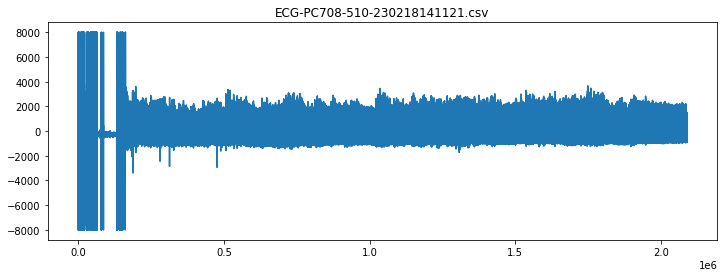

In [314]:
row = file_log.loc[7,:]
print(row['Signal'])

if row['Signal'] == 'ECG':
    V = pd.read_csv(row['FullLoc'])
    V['DateTime'] = pd.to_datetime(V['DateTime'])
    V['ECG'] = V[' Lead 1'].clip(-8000, 8000) # note the leading space on ' Lead 1'. It slike that in Equivitals qiosk outputs.
    V['ECG'].plot(figsize=(12,4))
    plt.title(row['FileName'])
    plt.show()

ECG-PC708-510-230218141121.csv
2088352
[330.0, 4176.704, 165000, 2088352]
[Timestamp('2023-02-18 14:11:21.080000+0000', tz='UTC'), Timestamp('2023-02-18 15:20:58+0000', tz='UTC')]
[Timestamp('2023-02-18 14:16:51.080000+0000', tz='UTC'), Timestamp('2023-02-18 15:20:58+0000', tz='UTC')]


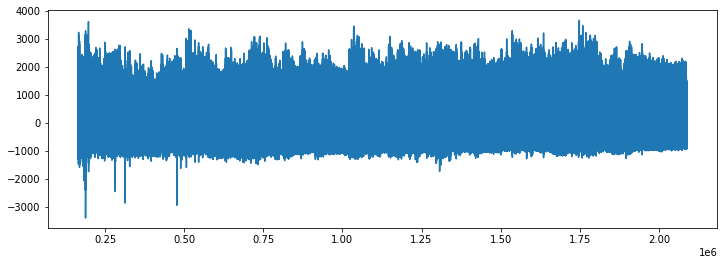

In [316]:
bad_cut =  165000 #160000 #165000 40000
end_cut = len(V) # or earlier 1600000, 2420000 # 1650000 # 2088000 #2470000#
data = V['ECG'][bad_cut:end_cut]

print(row['FileName'])
print(len(V['ECG']))
print([bad_cut/sample_rate,end_cut/sample_rate,bad_cut,end_cut])
print([V.iloc[0,0],V.iloc[-1,0]])
print([V.iloc[bad_cut,0],V.iloc[end_cut-1,0]])

plt.figure(figsize=(12,4))
plt.plot(data)
plt.show()

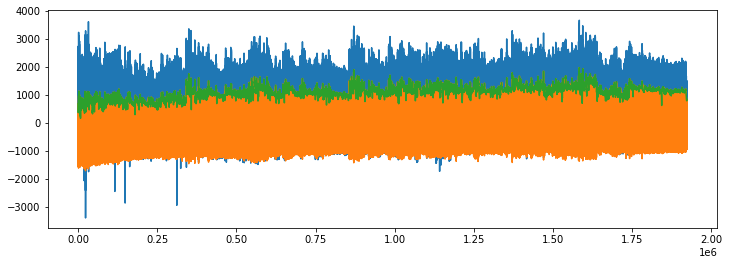

RR-PC708-510-230218141121.csv


,DateTime,Interbeat Interval (MS)
165250,2023-02-18 14:16:51.580000+00:00,534
165517,2023-02-18 14:16:52.114000+00:00,530
165782,2023-02-18 14:16:52.644000+00:00,528
166046,2023-02-18 14:16:53.172000+00:00,524
166308,2023-02-18 14:16:53.696000+00:00,524
...,...,...
2086642,2023-02-18 15:20:54.582000+00:00,638
2086961,2023-02-18 15:20:55.220000+00:00,640
2087281,2023-02-18 15:20:55.860000+00:00,634
2087598,2023-02-18 15:20:56.494000+00:00,630


In [317]:
data = V['ECG'][bad_cut:end_cut].values
plt.figure(figsize=(12,4))
plt.plot(data)

sample_rate = 500# Hz
filtered = hp.filter_signal(data, cutoff = 0.05, sample_rate = sample_rate, filtertype='notch')
wd, m = hp.process(hp.scale_data(filtered), sample_rate)

plt.plot(filtered)
plt.plot(wd['peaklist'],filtered[wd['peaklist']])
plt.show()

filename = '-'.join(['RR',str(row['ID']),str(row['DevName']),row['Date'].strftime(format='%y%m%d%H%M%S') + '.csv'])
print(filename)
IBIs = pd.DataFrame()
IBIs['DateTime'] = V.loc[np.array(wd['peaklist'][:-1])+bad_cut,'DateTime']
IBIs['Interbeat Interval (MS)'] = wd['RR_list'].astype('int')

IBIs.to_csv(ibi_out + filename,index = False)
IBIs

# Check cardiac activity for timing clues

In [321]:
concerts = ['RD', 'C1', 'C2', 'C3', 'C4', 'C5']
Piece_timings = pd.read_csv('./Timing/Concerttimes_DateTimeUTC.csv', index_col = 0)
dt_max = {}
for concert in concerts:
    Piece_timings.loc[:,concert] = pd.to_datetime(Piece_timings.loc[:,concert])
    dt_max[concert] = Piece_timings.loc[:,concert].max()
#dt_max
#Piece_timings

In [327]:
data_loc = '../Data/Movesense/EqForm_new/'
files = os.listdir(data_loc)
cols=['Signal','DevName','ID','Date','Session',
           'FileName', 'FileType','FileSize','RecStart','RecEnd',
           'Duration','FullLoc']
ms_files = pd.DataFrame(columns = cols)
i = 0
for f in files: 
    if f.endswith('.csv'):
        print(f)
        dets=f.split('-')
        V = pd.read_csv(data_loc + f)
        dt = pd.to_datetime(V['DateTime'])
        
        feilds = {'Signal':dets[0],
                  'DevName':int(dets[2]),
                  'ID':dets[1],
                  'Date':pd.to_datetime(int(dets[3].split('.')[0]),format="%y%m%d%H%M%S"),
                  'Session':'',
                  'FileName':f,
                  'FileType':'csv',
                  'FileSize': os.path.getsize(data_loc+f),
                  'RecStart':dt.iloc[0],
                  'RecEnd':dt.iloc[-1],
                  'Duration':(dt.iloc[-1]-dt.iloc[0]).total_seconds(),
                  'FullLoc':data_loc+f}
        ms_files.loc[i,feilds.keys()] = feilds
        i += 1
ms_files.sort_values('Date').reset_index(drop = 'True').to_csv('ms_log.csv')

FASTACC-PC708-620-230217092559.csv
ECG-PC706-537-230217075913.csv
RR-PC706-577-230215105831.csv
ECG-PC708-620-230217074533.csv
RR-PC706-587-230216074249.csv
FASTACC-PC708-510-230218141120.csv
ECG-PC708-596-230216093335.csv
FASTACC-PC706-537-230217075913.csv
ECG-PC708-620-230217092559.csv
FASTACC-PC708-620-230217074533.csv
ECG-PC708-510-230218141121.csv
FASTACC-PC708-596-230216093334.csv
RR-PC708-596-230216075246.csv
RR-PC708-596-230216093335.csv
FASTACC-PC708-596-230216075246.csv
ECG-PC706-587-230216074249.csv
RR-PC708-620-230217074533.csv
ECG-PC706-577-230215105831.csv
RR-PC706-537-230217075913.csv
ECG-PC708-596-230216075246.csv
FASTACC-PC706-587-230216074249.csv
RR-PC708-510-230218141121.csv
FASTACC-PC706-577-230215105831.csv
RR-PC708-620-230217092559.csv


In [330]:
ms_files= pd.read_csv('ms_log.csv',index_col=0)
ms_files.loc[:,'RecStart'] = pd.to_datetime(ms_files.loc[:,'RecStart'])
ms_files.loc[:,'RecEnd'] = pd.to_datetime(ms_files.loc[:,'RecEnd'])
for c in list(dt_max.keys()):
    print(c)
    Ind = ((ms_files.loc[:,'RecEnd']-dt_max[c])).dt.total_seconds().abs()<3600
    ms_files.loc[Ind,'Session']= c

ms_files.sort_values('Date').reset_index(drop = 'True').to_csv('ms_log.csv')#['Session']

RD
C1
C2
C3
C4
C5


In [331]:
ms_files

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,FullLoc
0,ECG,577,PC706,2023-02-15 10:58:31,RD,ECG-PC706-577-230215105831.csv,csv,63427634,2023-02-15 10:58:31.276000+00:00,2023-02-15 11:54:20+00:00,3348.724,../Data/Movesense/EqForm_new/ECG-PC706-577-230...
1,RR,577,PC706,2023-02-15 10:58:31,RD,RR-PC706-577-230215105831.csv,csv,128112,2023-02-15 11:06:43.782000+00:00,2023-02-15 11:54:18.828000+00:00,2855.046,../Data/Movesense/EqForm_new/RR-PC706-577-2302...
2,FASTACC,577,PC706,2023-02-15 10:58:31,RD,FASTACC-PC706-577-230215105831.csv,csv,61797344,2023-02-15 10:58:31.365000+00:00,2023-02-15 11:54:20+00:00,3348.635,../Data/Movesense/EqForm_new/FASTACC-PC706-577...
3,ECG,587,PC706,2023-02-16 07:42:49,C1,ECG-PC706-587-230216074249.csv,csv,95768710,2023-02-16 07:42:49.178000+00:00,2023-02-16 09:07:12+00:00,5062.822,../Data/Movesense/EqForm_new/ECG-PC706-587-230...
4,RR,587,PC706,2023-02-16 07:42:49,C1,RR-PC706-587-230216074249.csv,csv,233767,2023-02-16 07:56:09.430000+00:00,2023-02-16 09:07:10.964000+00:00,4261.534,../Data/Movesense/EqForm_new/RR-PC706-587-2302...
5,FASTACC,587,PC706,2023-02-16 07:42:49,C1,FASTACC-PC706-587-230216074249.csv,csv,93032955,2023-02-16 07:42:49.158000+00:00,2023-02-16 09:07:12+00:00,5062.842,../Data/Movesense/EqForm_new/FASTACC-PC706-587...
6,FASTACC,596,PC708,2023-02-16 07:52:46,C1,FASTACC-PC708-596-230216075246.csv,csv,93130993,2023-02-16 07:52:46.072000+00:00,2023-02-16 09:15:46+00:00,4979.928,../Data/Movesense/EqForm_new/FASTACC-PC708-596...
7,RR,596,PC708,2023-02-16 07:52:46,C1,RR-PC708-596-230216075246.csv,csv,291201,2023-02-16 07:58:06.380000+00:00,2023-02-16 09:15:45.108000+00:00,4658.728,../Data/Movesense/EqForm_new/RR-PC708-596-2302...
8,ECG,596,PC708,2023-02-16 07:52:46,C1,ECG-PC708-596-230216075246.csv,csv,94317106,2023-02-16 07:52:46.050000+00:00,2023-02-16 09:15:46+00:00,4979.950,../Data/Movesense/EqForm_new/ECG-PC708-596-230...
9,FASTACC,596,PC708,2023-02-16 09:33:34,C2,FASTACC-PC708-596-230216093334.csv,csv,90450677,2023-02-16 09:33:34.998000+00:00,2023-02-16 10:54:28+00:00,4853.002,../Data/Movesense/EqForm_new/FASTACC-PC708-596...


# correct the timestamps

Initially this was needed to make the conversion from CET to UTC. This has since been corrected elswhere

# Eval Cardio against concert events

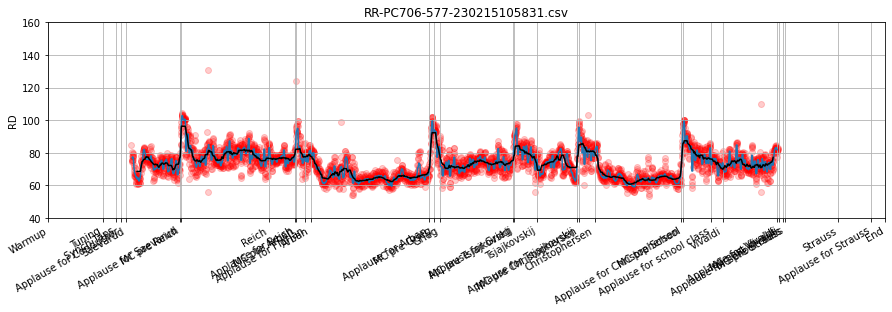

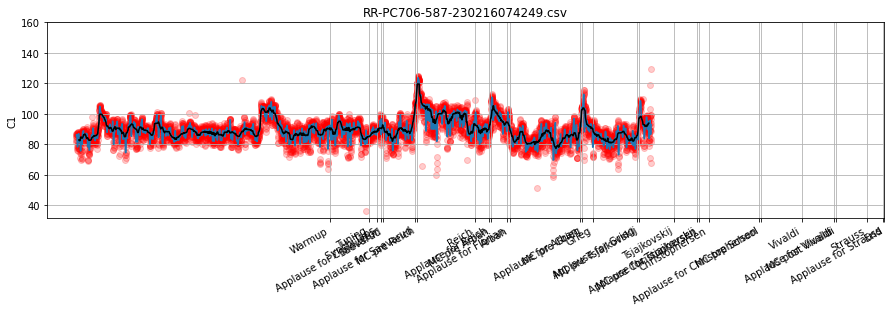

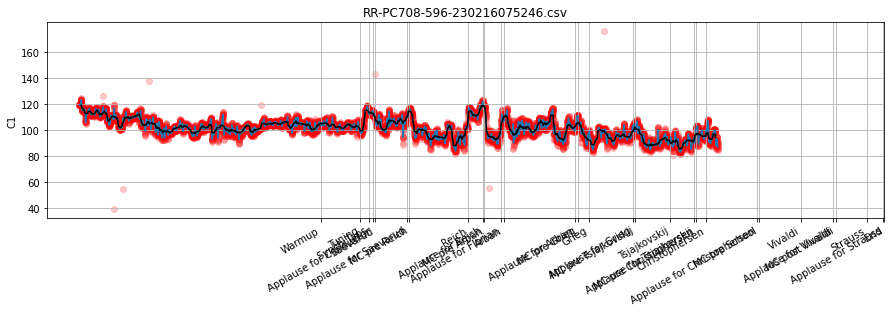

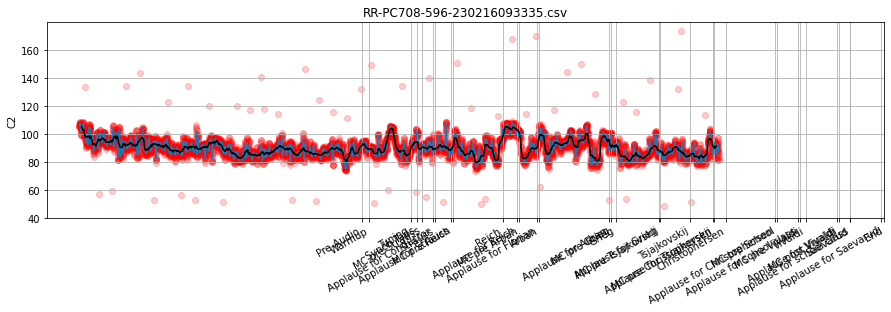

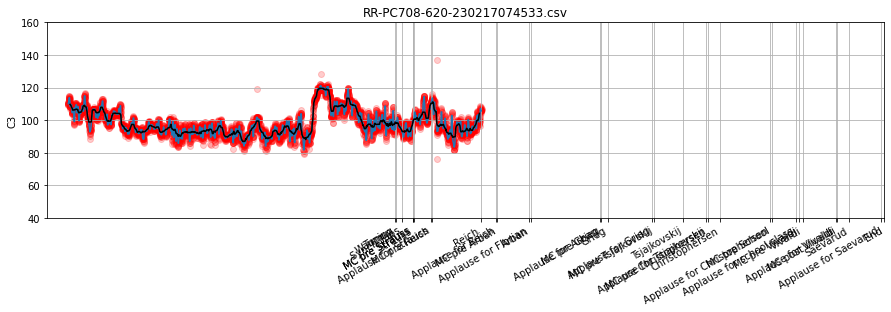

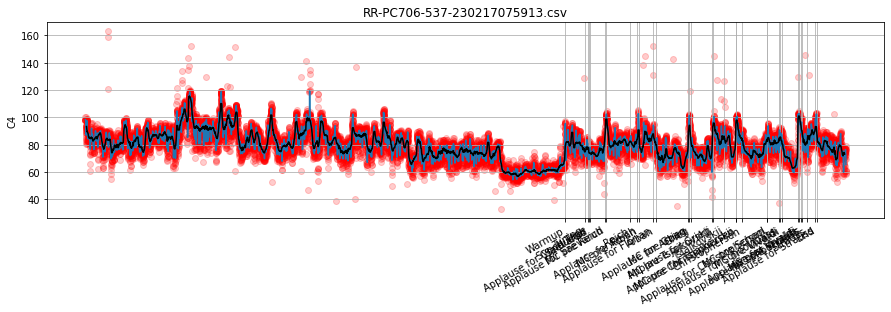

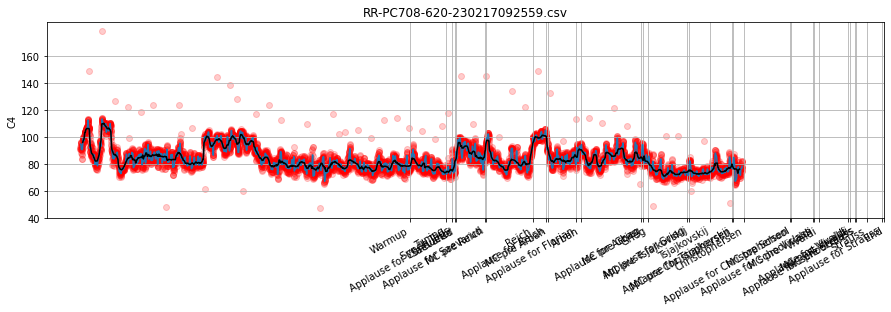

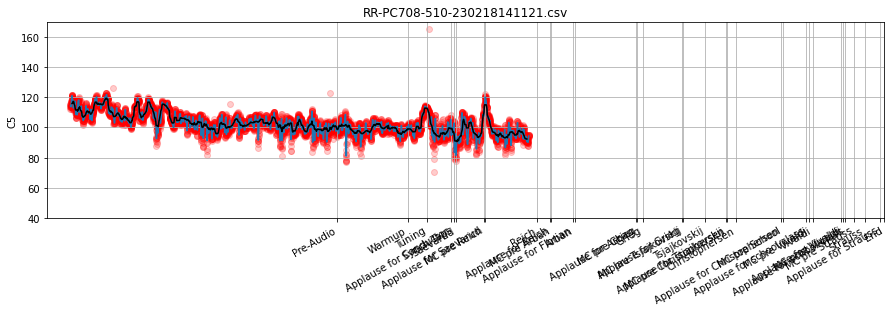

In [333]:
sf = 25

for i,row in ms_files.iterrows():
    if row['Signal']=='RR':
        V = pd.read_csv(row['FullLoc'])
        V['DateTime'] = pd.to_datetime(V['DateTime'])
        df_raw = pd.DataFrame()
        df_raw['dev_dTime'] = V['DateTime'] 
        
        fig, (ax) = plt.subplots(1, 1,figsize = [15,4])
        
        # cut extreme outliers
        V = V.loc[V['Interbeat Interval (MS)']>330,:]
        sig_t = (V['DateTime']-V['DateTime'][0]).dt.total_seconds()
        time_s = np.round(np.linspace(0,sig_t.iloc[-1],int(sf*(sig_t.iloc[-1])),endpoint=False),3)
        time_dt = V['DateTime'][0] + pd.to_timedelta(time_s,unit='s')
        sig_v = V['Interbeat Interval (MS)']

        #df_sig = pd.DataFrame(index = time_s)
        df_sig = pd.DataFrame(index = time_dt)
        ax1 = ax
#         ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
        ax1.scatter(x =V['DateTime'],y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

        HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
        f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
        df_sig.loc[:,'10 bt Median'] = f(time_s)
        df_sig['10 bt Median'].plot(ax = ax1,label = '10 bt Median')

        HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
        f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
        df_sig.loc[:,'60bMed'] = f(time_s)
        df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 bt Median')
        
        ax1.set_yticks([40,60,80,100,120,140,160])
        if not pd.isna(row['Session']):
            ticks = Piece_timings.loc[:,['Event',row['Session']]].copy()
            ticks = ticks.loc[~ticks[row['Session']].isna(),:].copy()
            ax1.set_xticks(ticks.loc[:,row['Session']])
            ax1.set_xticklabels(ticks.loc[:,'Event'])
            ax1.set_ylabel(row['Session'])
        plt.grid()
        plt.title(row['FileName'])
        plt.savefig('./plots/Movesense_'+row['ID']+'_BPM_'+ row['Session']+ '_'+str(row['DevName'])+'.png',dpi = 200)

        plt.show()

### from this we learn
The Movesense measurements were truncated to a little over an hour. Not sure why, but that is what is making the results so hard to interprete time wise. But from the cardiac activity it looks like we can ID which was worn by whom and get the right timezone so that trimmed files can be added to the correct equivital plots. 

Here we will go through each recordings, one at a time, to correct alignment manually as best we can and then save to the correct folders. 

We want to preserve: ACC, IBI, ECG, all cut to the correct range for a concert and saved under the right performer code.

In [67]:
ms_files['DevName'].unique()

array([545, 577, 587, 596, 620, 537, 510])

In [94]:
DevID = 587
files_rec = ms_files.loc[ms_files['DevName']==DevID].reset_index(drop = True)
files_rec

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,FullLoc
0,RR,587,PC706,2023-02-16 08:42:49,C1,RR-PC706-587-230216084249.csv,csv,226879,2023-02-16 10:05:10.020000+00:00,2023-02-16 10:05:10.020000+00:00,4140.590,../Data/Movesense/EqForm/RR-PC706-587-23021608...
1,ECG,587,PC706,2023-02-16 08:42:49,C1,ECG-PC706-587-230216084249.csv,csv,95768710,2023-02-16 10:07:12+00:00,2023-02-16 10:07:12+00:00,5062.822,../Data/Movesense/EqForm/ECG-PC706-587-2302160...
2,FASTACC,587,PC706,2023-02-16 08:42:49,C1,FASTACC-PC706-587-230216084249.csv,csv,93032955,2023-02-16 10:07:12+00:00,2023-02-16 10:07:12+00:00,5062.842,../Data/Movesense/EqForm/FASTACC-PC706-587-230...


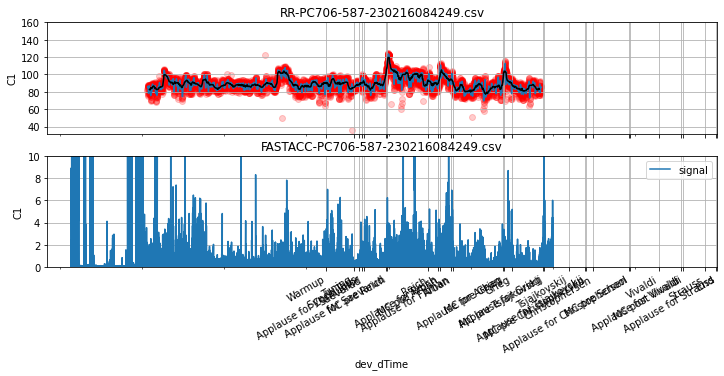

In [97]:
fig, (ax) = plt.subplots(2, 1,sharex=True,figsize = [12,5])


for i,row in files_rec.iterrows():
    if row['Signal']=='RR':
        V = pd.read_csv(row['FullLoc'])
        V['DateTime'] = pd.to_datetime(V['DateTime']) -pd.to_timedelta(3600,unit='s')
        df_raw = pd.DataFrame()
        df_raw['dev_dTime'] = V['DateTime'] 
        
        ax1 = ax[0]
        # cut extreme outliers
        V = V.loc[V['Interbeat Interval (MS)']>330,:]
        sig_t = (V['DateTime']-V['DateTime'][0]).dt.total_seconds()
        time_s = np.round(np.linspace(0,sig_t.iloc[-1],int(sf*(sig_t.iloc[-1])),endpoint=False),3)
        time_dt = V['DateTime'][0] + pd.to_timedelta(time_s,unit='s')
        sig_v = V['Interbeat Interval (MS)']

        #df_sig = pd.DataFrame(index = time_s)
        df_sig = pd.DataFrame(index = time_dt)
#         ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
        ax1.scatter(x =V['DateTime'],y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

        HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
        f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
        df_sig.loc[:,'10 bt Median'] = f(time_s)
        df_sig['10 bt Median'].plot(ax = ax1,label = '10 bt Median')

        HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
        f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
        df_sig.loc[:,'60bMed'] = f(time_s)
        df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 bt Median')
        
        ax1.set_yticks([40,60,80,100,120,140,160])
        if not pd.isna(row['Session']):
            ticks = Piece_timings.loc[:,['Event',row['Session']]].copy()
            ticks = ticks.loc[~ticks[row['Session']].isna(),:].copy()
            ax1.set_xticks(ticks.loc[:,row['Session']])
            ax1.set_xticklabels(ticks.loc[:,'Event'])
            ax1.set_ylabel(row['Session'])
        ax1.grid()
        ax1.set_title(row['FileName']) 
        
    if row['Signal']=='FASTACC':
        V = pd.read_csv(row['FullLoc'])
        V['DateTime'] = pd.to_datetime(V['DateTime']) -pd.to_timedelta(3600,unit='s')
        df_raw = pd.DataFrame()
        df_raw['dev_dTime'] = V['DateTime'] 
        df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]

        df_raw['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
        
        ax1 = ax[1]
        df_raw.plot(x = 'dev_dTime',y = 'signal',ax=ax1)
        ax1.set_ylim([0,10])
        ax1.set_title(row['FileName'])
        if not pd.isna(row['Session']):
            ticks = Piece_timings.loc[:,['Event',row['Session']]].copy()
            ticks = ticks.loc[~ticks[row['Session']].isna(),:].copy()
            ax1.set_xticks(ticks.loc[:,row['Session']])
            ax1.set_xticklabels(ticks.loc[:,'Event'])
            ax1.set_ylabel(row['Session'])
        ax1.grid()
plt.show() 

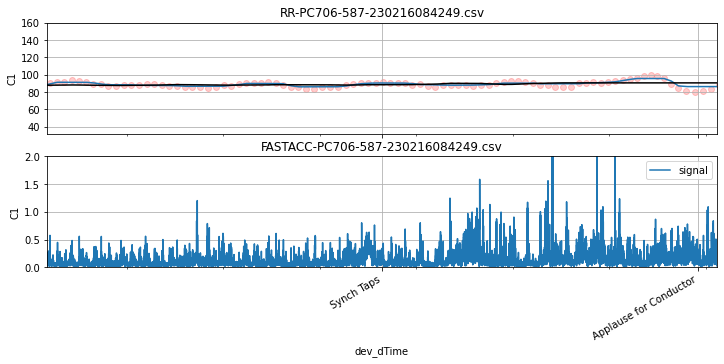

In [99]:
fig, (ax) = plt.subplots(2, 1,sharex=True,figsize = [12,5])


for i,row in files_rec.iterrows():
    if row['Signal']=='RR':
        V = pd.read_csv(row['FullLoc'])
        V['DateTime'] = pd.to_datetime(V['DateTime']) -pd.to_timedelta(3600,unit='s')
        df_raw = pd.DataFrame()
        df_raw['dev_dTime'] = V['DateTime'] 
        
        ax1 = ax[0]
        # cut extreme outliers
        V = V.loc[V['Interbeat Interval (MS)']>330,:]
        sig_t = (V['DateTime']-V['DateTime'][0]).dt.total_seconds()
        time_s = np.round(np.linspace(0,sig_t.iloc[-1],int(sf*(sig_t.iloc[-1])),endpoint=False),3)
        time_dt = V['DateTime'][0] + pd.to_timedelta(time_s,unit='s')
        sig_v = V['Interbeat Interval (MS)']

        #df_sig = pd.DataFrame(index = time_s)
        df_sig = pd.DataFrame(index = time_dt)
#         ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
        ax1.scatter(x =V['DateTime'],y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

        HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
        f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
        df_sig.loc[:,'10 bt Median'] = f(time_s)
        df_sig['10 bt Median'].plot(ax = ax1,label = '10 bt Median')

        HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
        f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
        df_sig.loc[:,'60bMed'] = f(time_s)
        df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 bt Median')
        
        ax1.set_yticks([40,60,80,100,120,140,160])
        if not pd.isna(row['Session']):
            ticks = Piece_timings.loc[:,['Event',row['Session']]].copy()
            ticks = ticks.loc[~ticks[row['Session']].isna(),:].copy()
            ax1.set_xticks(ticks.loc[:,row['Session']])
            ax1.set_xticklabels(ticks.loc[:,'Event'])
            ax1.set_ylabel(row['Session'])
        ax1.grid()
        ax1.set_title(row['FileName']) 
        
    if row['Signal']=='FASTACC':
        V = pd.read_csv(row['FullLoc'])
        V['DateTime'] = pd.to_datetime(V['DateTime']) -pd.to_timedelta(3600,unit='s')
        df_raw = pd.DataFrame()
        df_raw['dev_dTime'] = V['DateTime'] 
        df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]

        df_raw['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
        
        ax1 = ax[1]
        df_raw.plot(x = 'dev_dTime',y = 'signal',ax=ax1)
        ax1.set_ylim([0,2])
        ax1.set_title(row['FileName'])
        if not pd.isna(row['Session']):
            ticks = Piece_timings.loc[:,['Event',row['Session']]].copy()
            ticks = ticks.loc[~ticks[row['Session']].isna(),:].copy()
            ax1.set_xticks(ticks.loc[:,row['Session']])
            ax1.set_xticklabels(ticks.loc[:,'Event'])
            ax1.set_ylabel(row['Session'])
        ax1.grid(),
ax1.set_xlim([Piece_timings.loc[onset,row['Session']]-pd.to_timedelta(spread,unit='s'),Piece_timings.loc[onset,row['Session']]+pd.to_timedelta(spread,unit='s')])
plt.show() 

In [91]:
onset = 3
spread = 30

577 is the MC (PC706) during the dress rehearsal DR. Can't it can't be aligned, but it looks to be within 10 seconds. Recording ends during vivaldi.  

587 is the MC (PC706) during the first concert C1. Maybe there are synch taps but there is also footfall.


## TODO
use cardio details to double check which responses below to which participant and then try to find parallels related to their performance work each day.

As we basically don't have any chance to use the tapping cues to align these weird weird recotdings

Lessons: write down the time these devices are turned on and off. The clocks are a mystery right now. The values don't make sense. Maybe also talk to Hugh.